# Tank2 and Tank5 phase regulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import sklearn.mixture
from sklearn.linear_model import LinearRegression
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

%matplotlib widget
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["savefig.format"] = 'pdf'
plt.rc("axes",prop_cycle= plt.cycler("color", plt.cm.tab20.colors))

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import LearningRateScheduler

print(tf.__version__)

2.12.0


## DNN regression models

The base model contains the following layers:

* The normalization layer.
* N hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear output layer.

We also test a model without input normalization layer.

In [3]:
def build_and_compile_model(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(32, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_len(norm, init_lr, numlabel):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(32, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(int(numlabel))
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_square(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model
def build_and_compile_model_nobatch(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'), #200
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model


def build_and_compile_model_nonorm(inputs,init_lr):
  model = keras.Sequential([
      keras.Input(shape=(inputs,)),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_LSTM(init_lr,numlabel):
  model = keras.Sequential([
      layers.LSTM(128, return_sequences=True),
      layers.LSTM(128),
      layers.Dense(int(numlabel))
  ])
  model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

## Define learning schedules and training

In [4]:
# Define learning schedules 

initial_lr = 0.001

def lr_time_based_decay(epoch, lr):
    epochs = 400
    decay = initial_lr / epochs
    return lr * 1 / (1 + decay * epoch)


def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 200.0
    return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_lr * math.exp(-k*epoch)



In [5]:
def train_model(model,features,labels,eps,lrs=None):
    if lrs is None:
        history = model.fit(
            features, 
            labels,
            validation_split=0.2,
            batch_size=64, #30
            verbose=0,
            epochs=int(eps)
        )
    else:
        history = model.fit(
            features, 
            labels, 
            validation_split=0.2,
            batch_size=64,
            verbose=0,
            epochs=int(eps), 
            callbacks=[LearningRateScheduler(lrs, verbose=0)],
        )
    return history

## Define plotting functions

In [6]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_multi_loss(histories):
    fig, ax = plt.subplots(len(histories),1,figsize=(9,9))
    for i in range(len(histories)):
        ax[i].plot(histories[i].history['loss'], label='loss')
        ax[i].plot(histories[i].history['val_loss'], label='val_loss')
        ax[i].set_ylim([0, 0.5])
        ax[i].set(xlabel='Epoch', ylabel='Loss')
        ax[i].legend()
        ax[i].grid(True)
        
    fig.tight_layout()


In [7]:
def plot_2dhist(predictions,labels):

    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5))
    fig.tight_layout()
    devs = ['V5QSET','RFQ','Buncher']
    
    if labels.shape[1] ==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        h = ax[i].hist2d(labels.iloc[:,i], predictions[:,i], bins=40, cmin=1, cmap='seismic')
        #ax.set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        ax[i].set(title='%s'%key)
        ax[i].tick_params(axis='both',labelsize=14)
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        ax[i].plot(lims, lims, color='k')
        fig.colorbar(h[3], ax=ax[i])

    fig.supylabel('Predicted $\Delta$ phase (deg)', fontsize=18)
    fig.suptitle('True $\Delta$ phase (deg)', y=0.05, fontsize=18)   
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.14)
    plt.subplots_adjust(right=0.96)  

In [8]:
def plot_2dscatter_many(predictions,labels):

    fig, ax = plt.subplots(1,int(labels[0].shape[1]), figsize=(5*int(labels[0].shape[1]),5))
    if labels[0].shape[1] ==1:
        ax = [ax]

    for i in range(labels[0].shape[1]):
        key = labels[0].columns[i]

        for j in range(len(labels)):
            ax[i].scatter(labels[j].iloc[:,i], predictions[j][:,i], label='Data %d'%j)
            #ax[i].fill_between(labels[j].iloc[:,i],[np.min(predictions[j][k,i]) for k in ],np.max(predictions[j][:,i]),alpha=0.5)
        ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min([np.min(pred[:,i]) for pred in predictions]),np.min([np.min(lab.iloc[:,i]) for lab in labels])),
                max(np.max([np.max(pred[:,i]) for pred in predictions]),np.max([np.max(lab.iloc[:,i]) for lab in labels]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        #print(lims)
        ax[i].plot(lims, lims, color='b')
        ax[i].legend(ncol=2,fontsize=14, loc='upper left')
    fig.tight_layout()

In [9]:
def plot_2dscatter(predictions,labels):

    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5))
    if labels.shape[1] ==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        ax[i].scatter(labels.iloc[:,i], predictions[:,i], color='r')
        ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        print(lims)
        ax[i].plot(lims, lims, color='b')    
    fig.tight_layout()

In [10]:
def plot_1derror(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    devs = ['phase set point']
    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5),sharey=False)
    fig.tight_layout()
    
    nbins=60
    if labels.shape[1]==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        error =(predictions[:,i] - labels.iloc[:,i])
        error = [e for e in error if e <3*np.std(error)]

        ax[i].hist(error, bins=nbins, color='r', edgecolor='k', alpha=0.65, label='Data')
        #ax[i].set(title='%s'%key ,xlabel='Prediction Error (deg)', ylabel='Count')
        ax[i].set(title='%s'%key)
        #ax[i].xaxis.label.set_size(13)
        #ax[i].yaxis.label.set_size(13)
        
        ers = np.array(error)[:,None]
        gmm = sklearn.mixture.GaussianMixture()  
        r = gmm.fit(ers)
        mean = r.means_[0, 0]
        sigma = np.sqrt(r.covariances_[0,0])
        textstr = '\n'.join((
                    r'$\mu=%.2f$' % (mean,),
                    r'$\sigma=%.2f$' % (sigma,)))
        print(textstr)                                                                                                                  
        xlin = np.linspace(np.min(error),np.max(error),1000).reshape(-1,1)                                                                                                                             
        pdf = np.exp(gmm.score_samples(xlin))
        binsize = (np.max(error) - np.min(error))/nbins
        ax[i].plot(xlin,pdf*(len(error)*binsize),color='k', label='Gauss fit')
        ax[i].text(0.05, 0.65, textstr, transform=ax[i].transAxes, color='k', fontsize=14,                                                                                
                           verticalalignment='top', bbox=props)
        ax[i].legend(fontsize=14, loc='upper left')
        ax[i].tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=18)
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize=18)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  


In [11]:
def plot_1derror_many(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)

    fig, ax = plt.subplots(1,int(labels[0].shape[1]), figsize=(5*int(labels[0].shape[1]),5),sharey=False)
    fig.tight_layout()
    if labels[0].shape[1]==1:
        ax = [ax]
    for i in range(labels[0].shape[1]):
        key = labels[0].columns[i]
        nbins=40
        for j in range(len(labels)):
            error =(predictions[j][:,i] - labels[j].iloc[:,i])
            error = [e for e in error if e <1*np.std(error)]
            if i not in[2,3]:
                ax[i].hist(error, bins=nbins, alpha=0.45, label='Data')
            else:
                ax[i].hist(error, bins=100, alpha=0.45, label='Data')
        ax[i].set(title='%s'%key)
        #ax[i].legend(fontsize=14, loc='upper left')
        ax[i].tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=18)
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize=18)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  


## Define data loading functions

In [12]:
def fetch_data(file,datacols,cuts,setdevs):
    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    setdevs = ['L:%s_'%d for d in setdevs]
    cols = [col for col in cols if col not in setdevs]
    
    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter')),axis=1, inplace=True)

    # apply data quality cuts
    if len(cuts)>0:
        subset.query(cuts,inplace=True)
    
    # augment jumps in phase data
    #subset['B:BQ3F'] = subset['B:BQF3'].apply(lambda x : x if x > 0 else x +360)
    subset.dropna()
    
    return subset

In [13]:
def fetch_reference(dataset,devs,setvals,stepsize):
    
    conds = ["(np.abs(dataset['%s']-%s)<%f)"%(d,s,k) for (d,s,k) in zip(devs,setvals,stepsize)]
    print(conds)
    #reference = dataset.loc[(np.abs(dataset[devs[0]]-setvals[0])<0.5)].mean()
    reference = dataset.loc[eval('&'.join(conds)).ravel()].mean()
    return reference

In [14]:
def fetch_slice(dataset,devs,setvals,stepsize):
    
    conds = ["(np.abs(dataset['%s']-%s)<%f)"%(d,s,k) for (d,s,k) in zip(devs,setvals,stepsize)]

    sliced = dataset.loc[eval('&'.join(conds)).ravel()]
    return sliced

In [15]:
def fetch_features_labels(dataset,targetdevs):
    features = dataset.copy()
    labelstr = list(dataset.filter(regex='|'.join(targetdevs)))
    labels = features.loc[:,labelstr]
    features.drop(columns=labelstr, inplace=True)
    
    return features,labels

In [16]:
# List of approximate BPM positions in meters
dist_data = [26.5,27.0, 43.5, 44.0,60.8, 77.0,78.3,79.6,
            80.8, 82.5, 84.4,
            88.2, 90.1, 92.1,
            96.3, 98.4, 100.6, 102.8,
            105.0, 109.6, 111.9,
            114.7, 116.7, 119.1, 121.6,
            124.0, 126.5, 129.6, 131.6,
            134.2, 136.8, 139.4, 141.6]
#D42 : 107.3

## 2-phase models: T2, T5 setting

In [17]:
onedegdata = r"..\Data\untitled folder 2\devicescan_26042023.csv"
files =[r"..\Data\BS2\BEAM STUDY 14DEC2022\devicescan.csv", r"..\Data\BS1\BEAM STUDY 09OCT2022\devicescan_rfq_t2_t5.csv"]

file = r"..\Data\buncher-variant\2023_06_13_MEBT_BuncherT3_devicescan_Event0A.csv"

cavs = ['L:RFQPAH','L:V2QSET','L:V5QSET']
cavs2 = ['L:RFBPAH', 'L:V3QSET']
#cavs = ['L:V2QSET','L:V5QSET']

path = ""
dfs = [fetch_data('%s%s'%(path,f),cavs+['BF','BPM'],'',['%s_R'%c[2:] for c in cavs]) for f in files]

dfs = [df.drop(list(df.filter(regex=r'20|B:|SS|SQT|2OF|D42')),axis=1) for df in dfs]

dfs2 = fetch_data(file, cavs2 + ['BF', 'BPM'], '', ['%s_R'%c[2:] for c in cavs2])
dfs2 = dfs2.drop(list(dfs2.filter(regex=r'20|B:|SS|SQT|2OF|D42')),axis=1)


# quality cuts 
dfs[0].iloc[0,:] = dfs[0].iloc[1,:]
dfs[0].iloc[99,:] = dfs[0].iloc[100,:]
dfs[0].iloc[297,:] = dfs[0].iloc[298,:]
dfs[0].iloc[1386,:] = dfs[0].iloc[1387,:]
dfs[0].iloc[1477,:] = dfs[0].iloc[1478,:]
dfs[0].iloc[1683,:] = dfs[0].iloc[1684,:]
dfs[0].iloc[1738,:] = dfs[0].iloc[1739,:]
dfs[0].iloc[2574,:] = dfs[0].iloc[2575,:]
dfs[0].iloc[2673,:] = dfs[0].iloc[2674,:]
dfs[0].iloc[2970,:] = dfs[0].iloc[2971,:]
dfs[0].iloc[3960,:] = dfs[0].iloc[3961,:]
dfs[0].iloc[3982,:] = dfs[0].iloc[3983,:]
dfs[0].iloc[4950,:] = dfs[0].iloc[4951,:]
dfs[0].iloc[5346,:] = dfs[0].iloc[5347,:]
dfs[0].iloc[5445,:] = dfs[0].iloc[5446,:]
dfs[0].iloc[5841,:] = dfs[0].iloc[5842,:]
dfs[0].iloc[5940,:] = dfs[0].iloc[5941,:]
dfs[0].iloc[6435,:] = dfs[0].iloc[6436,:]
dfs[0].iloc[6534,:] = dfs[0].iloc[6535,:]
dfs[0].iloc[7128,:] = dfs[0].iloc[7129,:]
dfs[0].iloc[7326,:] = dfs[0].iloc[7327,:]
dfs[0].iloc[7623,:] = dfs[0].iloc[7624,:]
dfs[0].iloc[7821,:] = dfs[0].iloc[7822,:]
dfs[0].iloc[8118,:] = dfs[0].iloc[8119,:]
dfs[0].iloc[8910,:] = dfs[0].iloc[8911,:]
dfs[0].iloc[9207,:] = dfs[0].iloc[9208,:]
dfs[0].iloc[9306,:] = dfs[0].iloc[9307,:]
dfs[0].iloc[9603,:] = dfs[0].iloc[9604,:]
dfs[0].iloc[9801,:] = dfs[0].iloc[9802,:]
dfs[0].iloc[10098,:] = dfs[0].iloc[10099,:]
dfs[0].iloc[10494,:] = dfs[0].iloc[10495,:]
dfs[0].iloc[10890,:] = dfs[0].iloc[10891,:]
dfs[0].iloc[10989,:] = dfs[0].iloc[10990,:]
dfs[0].iloc[11088,:] = dfs[0].iloc[11089,:]
dfs[0].iloc[11286,:] = dfs[0].iloc[11287,:]
dfs[0].iloc[11884,:] = dfs[0].iloc[11885,:]
dfs[0] = dfs[0].iloc[:-1,:]


dfs[0] = dfs[0].loc[(dfs[0]['L:BPM3OF']>0)& 
                    (dfs[0]['L:BPM4IF']>0) & (dfs[0]['L:BPM5IF']<-87) & (dfs[0]['L:D13BF']<-17.5)&
                    (dfs[0]['L:D41BF']<-150)& (dfs[0]['L:D52BF']<-44)& (dfs[0]['L:D72BF']<-65)]

dfs[1].iloc[0,:] = dfs[1].iloc[1,:]
dfs[1].iloc[5940] = dfs[1].iloc[5941]
dfs[1] = dfs[1].iloc[:-1,:]

meds = [[np.median(df[c]) for c in cavs] for df in dfs]
#print(meds)
meds2 = [np.median(dfs2[c]) for c in cavs2]

stepsize = [[3.,0.5,0.3],[3.9,0.35,0.4]]

refs = [fetch_reference(df,cavs,med,step) for df,med,step in zip(dfs,meds,stepsize)]
#print(refs)
refs2 = fetch_reference(dfs2, cavs2, meds2, [5.0,5.0])

ddfs = [df-ref for df,ref in zip(dfs,refs)]
ddfs2 = dfs2 - refs2

df1deg = fetch_data('%s'%onedegdata,cavs[1:]+['BF','BPM'],'',['%s_R'%c[2:] for c in cavs[1:]])
df1deg = df1deg.drop(list(df1deg.filter(regex=r'20|B:|SS|SQT|2OF|D42')),axis=1)
df1deg = df1deg.iloc[:-1,:]
df1deg['L:BPM5OF'] = df1deg['L:BPM5OF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D53BF'] = df1deg['L:D53BF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D33BF'] = df1deg['L:D33BF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D41BF'] = df1deg['L:D41BF'].apply(lambda x : x if x > 0 else x +360)
df1deg = df1deg.loc[(df1deg['L:D72BF']<-65) & (df1deg['L:BPM4IF']>95) & (df1deg['L:D23BF']<100)]

ref1deg =fetch_reference(df1deg,cavs[1:],[np.median(df1deg[c]) for c in cavs[1:]],[0.99,0.99])
ddf1deg = df1deg-ref1deg



["(np.abs(dataset['L:RFQPAH']-178.57666015625)<3.000000)", "(np.abs(dataset['L:V2QSET']--26.5)<0.500000)", "(np.abs(dataset['L:V5QSET']--32.40999984741211)<0.300000)"]
["(np.abs(dataset['L:RFQPAH']-180.2978515625)<3.900000)", "(np.abs(dataset['L:V2QSET']--26.5)<0.350000)", "(np.abs(dataset['L:V5QSET']--34.280033111572266)<0.400000)"]
["(np.abs(dataset['L:RFBPAH']-225.041015625)<5.000000)", "(np.abs(dataset['L:V3QSET']--21.02101325988769)<5.000000)"]
["(np.abs(dataset['L:V2QSET']--26.5)<0.990000)", "(np.abs(dataset['L:V5QSET']--31.715068817138672)<0.990000)"]


In [18]:
dfs2

,L:RFBPAH,L:V3QSET,L:BPM3IF,L:BPM3OF,L:BPM4IF,L:BPM5IF,L:BPM5OF,L:D02BF,L:D03BF,L:D11BF,...,L:D53BF,L:D54BF,L:D61BF,L:D62BF,L:D63BF,L:D64BF,L:D71BF,L:D72BF,L:D73BF,L:D74BF
0,224.992432,-21.000000,96.652222,84.885864,105.188599,86.588745,-164.031372,117.355957,-95.773315,100.651245,...,176.879883,-137.032471,2.856445,77.211914,31.717529,41.852417,-82.210693,-74.185181,100.195312,98.679199
1,226.547119,-20.541798,96.053467,84.907837,105.034790,87.335815,-164.756470,116.927490,-95.811768,100.827026,...,177.330322,-137.526855,3.065186,77.365723,31.398926,41.709595,-82.474365,-74.591675,99.651489,99.371338
2,227.943909,-20.541798,95.300903,84.331055,104.490967,87.247925,-164.767456,116.927490,-95.811768,100.145874,...,177.258911,-137.526855,3.065186,77.189941,31.398926,41.709595,-82.474365,-74.591675,99.651489,99.371338
3,229.049194,-20.107969,94.899902,84.226685,104.359131,87.940063,-165.388184,116.773682,-96.102905,100.393066,...,177.385254,-136.466675,3.444214,77.415161,31.558228,41.456909,-82.760010,-75.997925,99.382324,98.201294
4,229.753662,-19.721594,94.680176,84.331055,104.392090,88.121338,-165.119019,116.658325,-95.998535,101.255493,...,177.615967,-136.362305,3.422241,77.459106,31.387939,40.880127,-82.946777,-75.053101,99.173584,98.920898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,219.988281,-22.830212,98.959351,85.676880,106.100464,85.275879,-163.245850,118.240356,-95.690918,100.382080,...,176.583252,-137.697144,2.301636,77.129517,31.904297,42.105103,-81.502075,-73.333740,101.145630,100.810547
295,220.231201,-22.596779,98.915405,85.682373,106.177368,84.940796,-162.756958,118.399658,-94.943848,100.250244,...,176.566772,-138.559570,2.169800,77.003174,31.755981,42.500610,-81.392212,-73.229370,101.173096,100.997314
296,220.935669,-22.278406,98.503418,85.468140,105.935669,85.385742,-163.311768,117.932739,-95.454712,99.986572,...,176.577759,-137.488403,2.532349,77.058105,31.679077,42.242432,-81.738281,-73.729248,100.854492,99.519653
297,222.040955,-21.892031,98.261719,85.627441,106.023560,85.545044,-163.558960,117.910767,-95.899658,100.387573,...,176.627197,-137.537842,2.411499,77.200928,31.882324,41.808472,-81.683350,-73.509521,100.876465,100.524902


(1085, 35)
(99, 35)


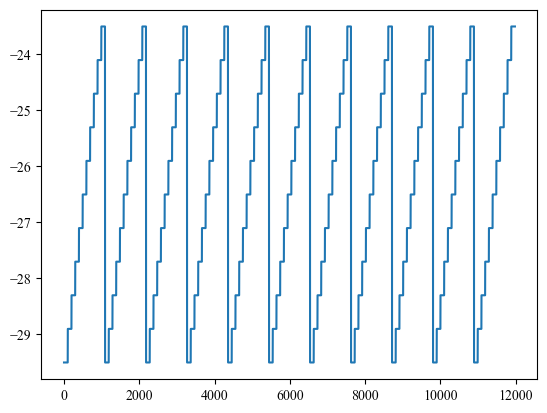

In [19]:
%matplotlib inline
plt.plot(dfs[0]['L:V2QSET'])
dff = dfs[0].loc[np.abs(dfs[0]['L:RFQPAH']-178.57)<1.]

dff =dff.sort_index().reset_index(drop=True)
dff.dropna(inplace=True)
print(dff.shape)
dff.head(10)
dff.to_csv('training_t2t5_oscillation.csv')

dfff = dfs[0].loc[(np.abs(dfs[0]['L:V2QSET']+26.5)<0.5) & (np.abs(dfs[0]['L:V5QSET']+32.41)<0.3)]
#dfff = dfs[0].loc[(np.abs(dfs[0]['L:V2QSET']-26.5)<0.3)]
dfff =dfff.sort_index().reset_index(drop=True)
dfff.dropna(inplace=True)
print(dfff.shape)
dfff.head(10)
dfff.to_csv('testing_upstream_oscillation.csv')
plt.show()

In [20]:
bpm = list(dff.columns)[3:]
res = dict(zip(bpm, dist_data))
import json

with open('sensor_positions.json', 'w') as fp:
    json.dump(res, fp)
    
baseline = dict(zip(cavs,meds[0]))
print(baseline)
with open('baseline_knobs.json', 'w') as fp:
    json.dump(baseline, fp)

{'L:RFQPAH': 178.57666015625, 'L:V2QSET': -26.5, 'L:V5QSET': -32.40999984741211}


## Plot BPM phase oscillation

In [21]:
ssdf = []
for i in range(3):
    cav = [c for c in cavs if c!=cavs[i]]
    ssdf.append([fetch_slice(df,cav,[0.,0.],[0.3,0.3]) for df in ddfs])
    #ssdf.append([fetch_slice(df,cav,[0.,0.],[0.9,0.9]) for df in ddfs])

ssdf =[[df.sort_index().reset_index(drop=True) for df in s] for s in ssdf]
ssdf = [[df.dropna() for df in s] for s in ssdf]

ssdf[0][1].drop([99],inplace=True)

print([[df.shape for df in s] for s in ssdf])

ssdfmed= [[df.groupby(np.arange(len(df))//9).median() for df in s] for s in ssdf]
#ssdfmed= [[df.groupby(np.arange(len(df))//10).mean() for df in s] for s in ssdf]
print([[df.shape for df in s] for s in ssdfmed])

[[(99, 35), (99, 35)], [(98, 35), (99, 35)], [(98, 35), (99, 35)]]
[[(11, 35), (11, 35)], [(11, 35), (11, 35)], [(11, 35), (11, 35)]]


6 11


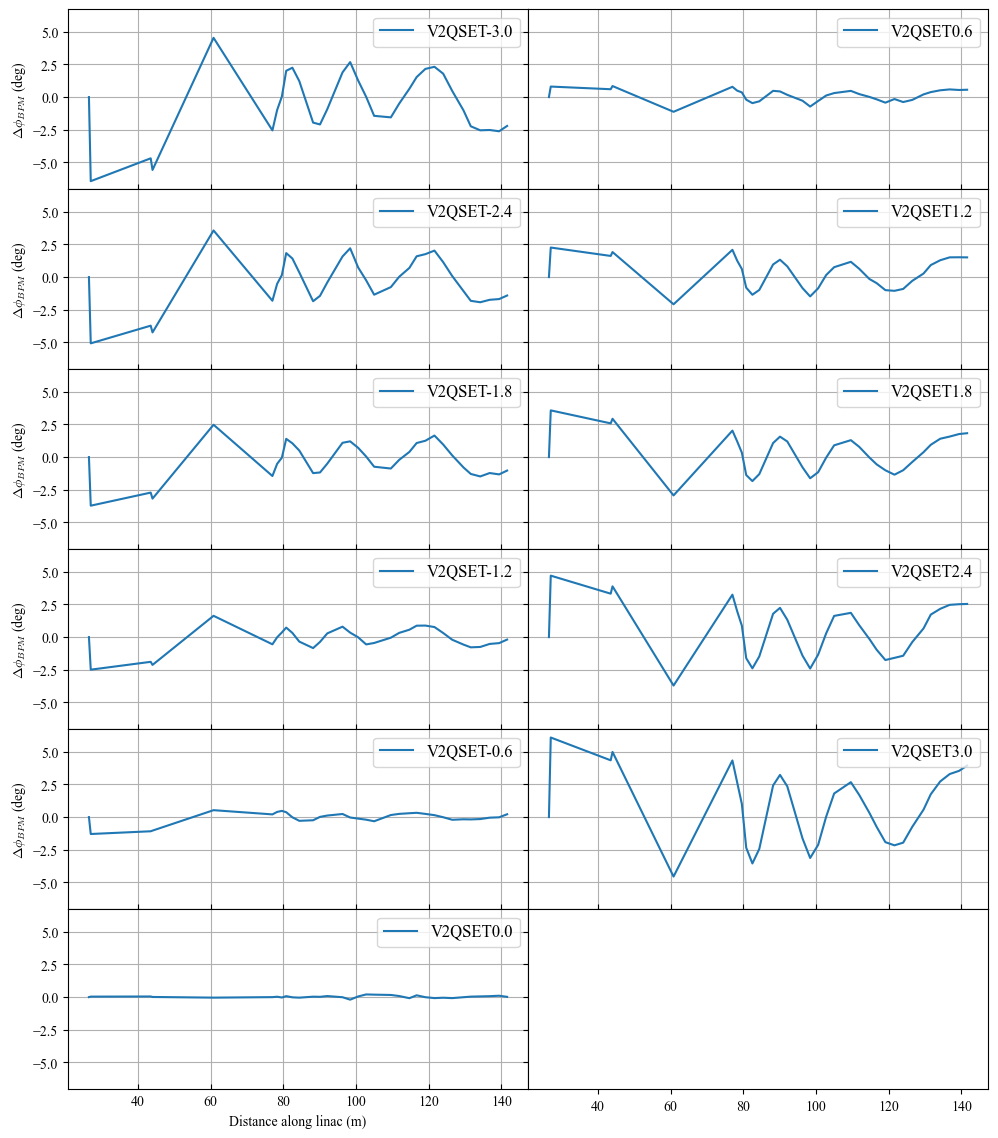

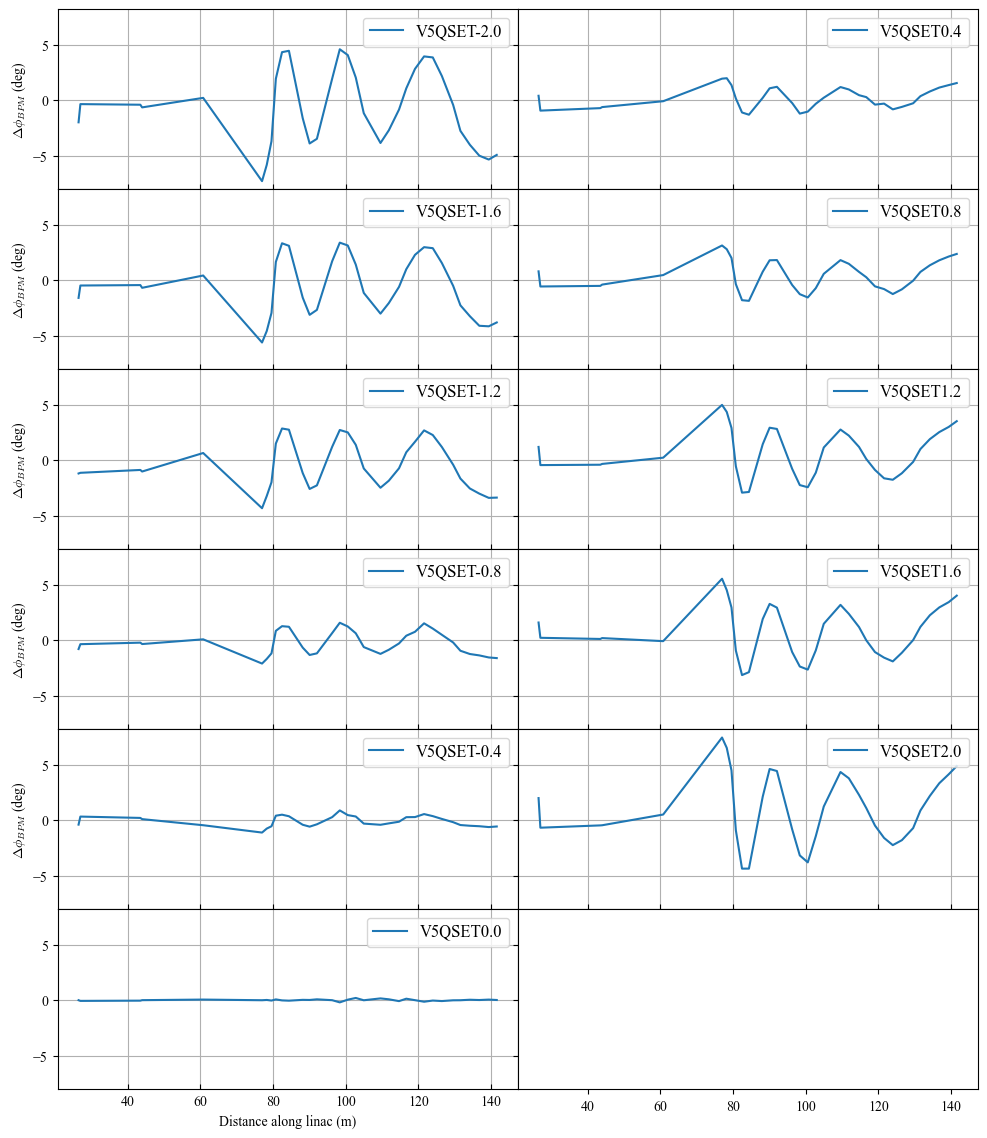

In [22]:
%matplotlib inline

nplots = ssdfmed[0][0].shape[0]
nrows = int(nplots/2) if nplots%2==0 else int(nplots/2)+1
print(nrows, nplots)
#devs = ['RFQPAH','V2QSET','V5QSET']
devs = ['test', 'V2QSET','V5QSET']
for i in (1, 2):
    fig, axs = plt.subplots(nrows,2, figsize=(10,12), sharex=True, sharey=True)
    for k in range(nplots):
        axs[int(k%(nplots/2))][int(k/(nplots/2))].plot(dist_data,ssdfmed[i][0].iloc[k,2:], label='%s%.1f'%(devs[i],ssdfmed[i][0].iloc[k,i]), marker='',linestyle='-')
        #axs[int(k%(nplots/2))][int(k/(nplots/2))].plot(dist_data,ssdfmed[i][1].iloc[k,3:-2], label='%s%.1f'%(devs[i],ssdfmed[i][1].iloc[k,0]), marker='o',linestyle='-')

        axs[int(k%(nplots/2))][int(k*2/(nplots))].legend(loc='upper right', fancybox=True, fontsize='large')
        axs[int(k%(nplots/2))][int(k*2/(nplots))].xaxis.set_tick_params(direction='in', which='major')
        axs[int(k%(nplots/2))][int(k*2/(nplots))].grid(True)
        #axs[int(k%(nplots/2))][int(k*2/(nplots))].set_ylim(-4.,5)
        if int(k%(nplots/2))==nrows-1:
            axs[int(k%(nplots/2))][int(k/(nplots/2))].set(xlabel='Distance along linac (m)')
        elif int(k/(nplots/2))%2==0:
            axs[int(k%(nplots/2))][int(k/(nplots/2))].set(ylabel='$\Delta \phi_{BPM}$ (deg)')
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(bottom=0.05)
    plt.subplots_adjust(top=0.95)
    plt.subplots_adjust(left=0.06)
    plt.subplots_adjust(right=0.98)

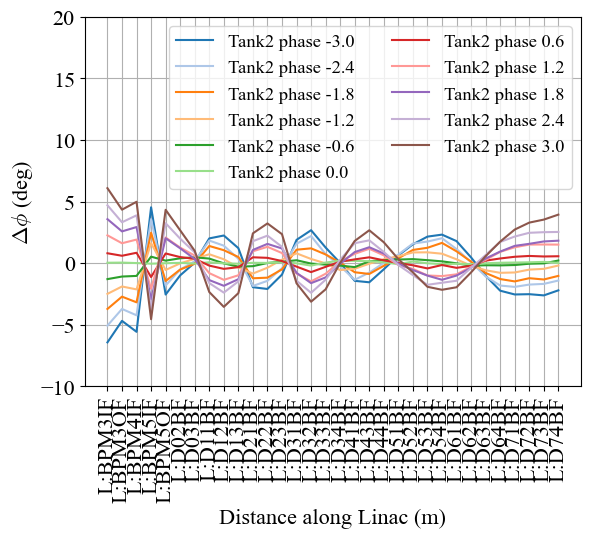

In [23]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
[plt.plot(ssdfmed[1][0].iloc[k,3:], label='Tank2 phase %2.1f'%(ssdfmed[1][0].iloc[k,1]), marker='',linestyle='-') for k in range(11) ]
#[plt.plot(ssdfmed[1][0].iloc[k,2:], label='Tank5 phase %2.1f'%(ssdfmed[1][0].iloc[k,1]), marker='',linestyle='-') for k in range(11) ]

plt.grid()
plt.legend(loc="upper right",fontsize = 'small',ncol=2)
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.ylim(-10, 20)
plt.xticks(rotation = 90);

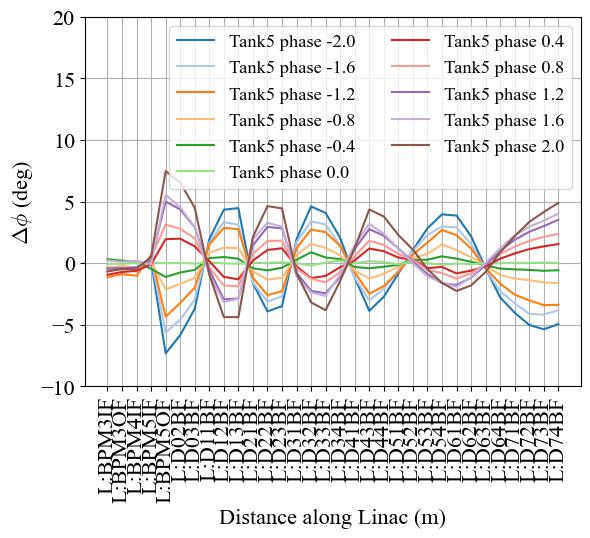

In [24]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
#[plt.plot(ssdfmed[0][0].iloc[k,2:], label='Tank2 phase %2.1f'%(ssdfmed[0][0].iloc[k,0]), marker='',linestyle='-') for k in range(11) ]
[plt.plot(ssdfmed[2][0].iloc[k,3:], label='Tank5 phase %2.1f'%(ssdfmed[2][0].iloc[k,2]), marker='',linestyle='-') for k in range(11) ]

plt.grid()
plt.legend(loc="upper right",fontsize = 'small',ncol=2)
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.ylim(-10, 20)
plt.xticks(rotation = 90);

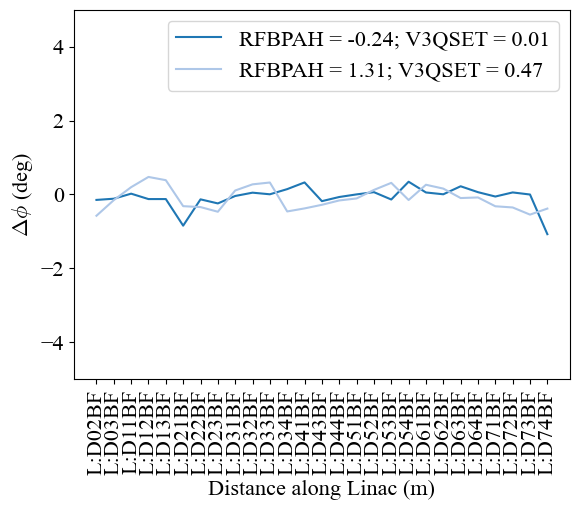

In [25]:
ar1 = ddfs2.iloc[0]
ar2 = ddfs2.iloc[1]

plt.plot(ar1[7:], label = 'RFBPAH = %.2f; V3QSET = %.2f'%tuple(ar1[:2]))
plt.plot(ar2[7:], label = 'RFBPAH = %.2f; V3QSET = %.2f'%tuple(ar2[:2]))
plt.legend()
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.xticks(rotation = 90);
plt.ylim(-5, 5)
plt.show()

# Error functions for different basis choice

In [26]:
def linear_estimator2(data, b_vec_1, b_vec_2):
    vec1 = ddfs2.iloc[b_vec_1, 3:]
    vec2 = ddfs2.iloc[b_vec_2, 3:]
    
    X = np.column_stack((vec1, vec2))
    model = LinearRegression()
    model.fit(X, data)
    
    return model.coef_

def error_calculator2(data, b_vec_1, b_vec_2):
    vec1 = ddfs2.iloc[b_vec_1, 3:]
    vec2 = ddfs2.iloc[b_vec_2, 3:]
    coeffs = linear_estimator2(data, b_vec_1, b_vec_2)
    best_fit = (vec1 * coeffs[0] + vec2 * coeffs[1])[5:]
    diff = np.diff(np.array([best_fit, np.array(data)[5:]]), axis=0)
    return np.sum(diff**2)
    
    

In [27]:
ddfs2.iloc[210, 0:2]

L:RFBPAH    0.232048
L:V3QSET   -1.840908
Name: 210, dtype: float64

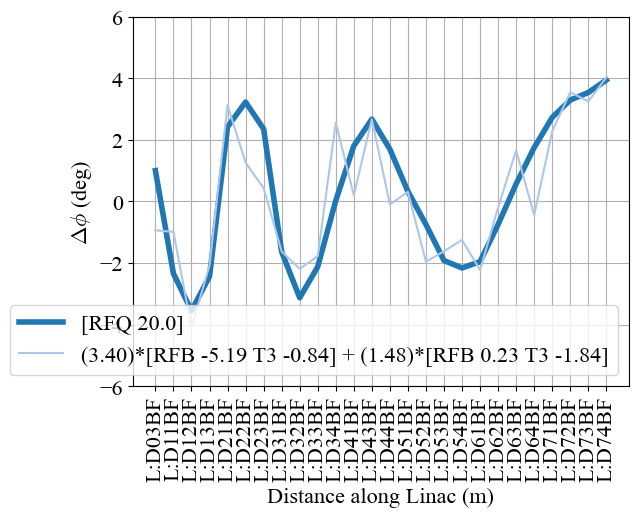

In [28]:
k2 = 10

test_ar = ssdfmed[1][0].iloc[k2, 4:]

coefficients = linear_estimator2(test_ar, 135, 210)

plt.plot(test_ar[5:], label = '[RFQ %.1f]'%(ssdfmed[0][0].iloc[k2, 0]), linewidth = 4)
plt.plot((ddfs2.iloc[135, 3:]* coefficients[0] + ddfs2.iloc[210, 3:] * coefficients[1])[5:], label = '(%.2f)*[RFB -5.19 T3 -0.84] + (%.2f)*[RFB 0.23 T3 -1.84]'%tuple(coefficients))
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.xticks(rotation = 90);
plt.legend(loc = 'lower right')
plt.ylim(-6, 6)
plt.grid()
plt.show()

## Scan across all possible choices in 299x299 grid

In [29]:
chi_sq_ar = np.zeros((299, 299))
for i in range(299):
    for j in range(299):
        if i == j: print(i)
        for k in range(11):
            chi_sq_ar[i, j] += error_calculator2(ssdfmed[0][0].iloc[k, 4:], i, j)
        
plt.imshow(chi_sq_ar, cmap = 'hot')
plt.colorbar()
plt.title('Total error on validation dataset')
plt.ylabel('T2 phase')
#plt.yticks(np.arange(11), (-3, -2.4, -1.8, -1.2, -0.6, 0, 0.6, 1.2, 1.8, 2.4, 3))
plt.xlabel('T5 phase')
#plt.xticks(np.arange(11), (-2, -1.6, -1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6, 2))
plt.show()
chi_sq_ar

0
1
2
3


KeyboardInterrupt: 

In [ ]:
plt.imshow(chi_sq_ar, cmap = 'hot')
plt.colorbar()
plt.title('Total error on validation dataset')
plt.ylabel('Index 1')
#plt.yticks(np.arange(11), (-3, -2.4, -1.8, -1.2, -0.6, 0, 0.6, 1.2, 1.8, 2.4, 3))
plt.xlabel('Index 2')
#plt.xticks(np.arange(11), (-2, -1.6, -1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6, 2))
plt.show()

In [ ]:
min_index = np.argmin(chi_sq_ar)
min_2d = np.unravel_index(min_index, chi_sq_ar.shape)
chi_sq_ar[min_2d]

In [ ]:
scan = ["L:RFBPAH", "L:V3QSET"]
for i in (0, 1): plt.plot(np.arange(len(ddfs2[scan[0]])), ddfs2[scan[i]], label = scan[i], marker = '.')
plt.legend()
plt.ylabel('$\Delta \phi$ (deg)')
plt.xlabel('Index')
plt.show()

In [ ]:
import scipy.signal as spsg
import scipy.fft as spft

peaks1, _ = spsg.find_peaks(ddfs2[scan[0]])
peaks2, _ = spsg.find_peaks(ddfs2[scan[1]])

plt.scatter(np.arange(len(ddfs2[scan[0]])), ddfs2[scan[0]], label = scan[0])
plt.plot(peaks1, ddfs2[scan[0]][peaks1], "x", color = 'orange')
plt.scatter(np.arange(len(ddfs2[scan[1]])), ddfs2[scan[1]], label = scan[1])
plt.plot(peaks2, ddfs2[scan[1]][peaks2], "x", color = 'red')
plt.plot(np.linspace(0, 300, 1000), np.ones(1000)*-1.4, color = 'green')
plt.plot(np.linspace(0, 300, 1000), np.ones(1000)*-1.6, color = 'green')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [ ]:
for i in range(len(ddfs2[scan[0]])):
    if ddfs2[scan[0]][i] < 1.5 and ddfs2[scan[0]][i] > 1.4: print(i)